# 03-Train-New-Model.ipynb

## Generate a training set from the example data downloaded in the previous notebook


In [24]:
import sys, os

root_dir = os.path.abspath('..')
sys.path.append(root_dir)

import glob
import torch
import voodoonet
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt




In [25]:
# define voodoo colormap
def get_voodoo_cmap():
    viridis = matplotlib.cm.get_cmap('viridis', 256)
    voodoo_cmap = viridis(np.linspace(0, 1, 256))
    voodoo_cmap[:1, :] = np.array([220/256, 220/256, 220/256, 1])
    voodoo_cmap = matplotlib.colors.ListedColormap(voodoo_cmap)
    return voodoo_cmap

# Fetch the training dataset from the sample data directory


In [26]:
# generate training data set
training_dataset_dir = os.path.join(root_dir, 'sample_data', 'training_datasets')
training_dataset_file_pattern = os.path.join(training_dataset_dir, 'training-data-set*.pt')
training_datasets = glob.glob(training_dataset_file_pattern)

print(f'Training data sets available: {training_datasets}')

Training data sets available: ['/Users/schimmel/code/voodoo_tutorial/Cloudnet-VOODOO-Processing/sample_data/training_datasets/training-data-set-eriswil--60-5dBZ.pt', '/Users/schimmel/code/voodoo_tutorial/Cloudnet-VOODOO-Processing/sample_data/training_datasets/training-data-set-eriswil--55-10dBZ.pt', '/Users/schimmel/code/voodoo_tutorial/Cloudnet-VOODOO-Processing/sample_data/training_datasets/training-data-set-eriswil--50-20dBZ.pt']


## Load pytorch training data

In [27]:
training_data = torch.load(training_datasets[0])
# returns a dictionary with keys 'features' and 'labels'
# features is a tensor of shape (n_samples, n_Doppler_bins, n_Time_bins)
# labels is a tensor of shape (n_samples, n_classes)

print(f'training_data["features"].shape: {training_data["features"].shape}')
print(f'training_data["labels"].shape: {training_data["labels"].shape}')


training_data["features"].shape: torch.Size([27614, 256, 6])
training_data["labels"].shape: torch.Size([27614])


## Create a quicklook of 25 random spectra in a 5x5 subplot



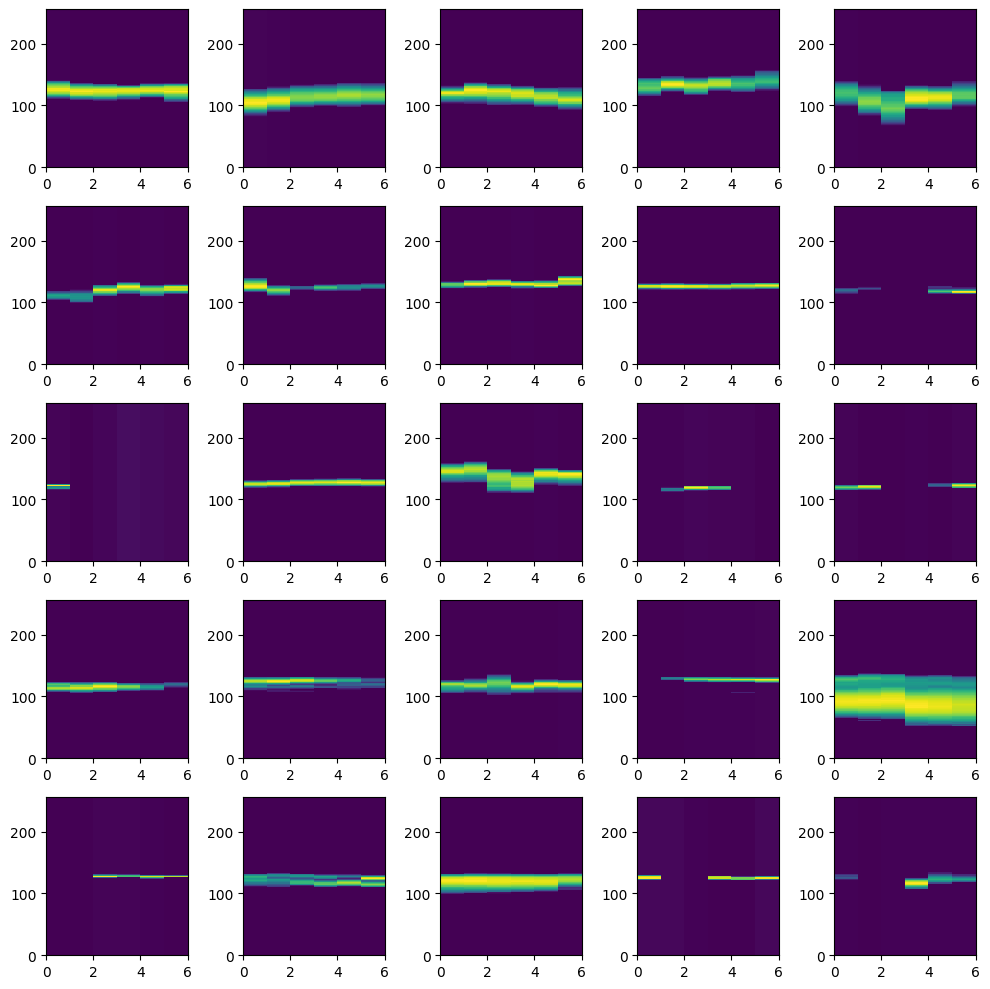

In [28]:
fig, axes = plt.subplots( nrows:=5, ncols:=5, figsize=(10, 10) )
random_indices = np.random.randint(0, training_data['features'].shape[0], size=nrows*ncols)

for i in range(nrows*ncols):
    axes.flat[i].pcolormesh(training_data['features'][random_indices[i], ...])

plt.tight_layout()

# Setup the options for VOODOO model training

## Check for CUDA or MPS availability

In [29]:
print(f'NVIDIA :: CUDA available: {torch.cuda.is_available()},  Number of CUDA devices: {torch.cuda.device_count()}')
# cuda:0, cuda:1, cuda:2, cuda:3

print(f'MacOS  :: MPS available: {torch.backends.mps.is_available()}, MPS built: {torch.backends.mps.is_built()}')


NVIDIA :: CUDA available: False,  Number of CUDA devices: 0
MacOS  :: MPS available: True, MPS built: True


## Define VOODOO model options

In [30]:
# generate training data set
model_options = voodoonet.utils.VoodooOptions(
    device="mps",           # use `mps` for training on MacOS, `cuda:X` for NVIDIA GPUs, else `cpu`
    progress_bar=True,      # show progress bar
    )


training_options = voodoonet.utils.VoodooTrainingOptions(
    dupe_droplets = 1,              # number of times to duplicate the cloud droplet containing classes to improve training, default: 1
    learning_rate = 1.0e-3,         # learning rate for the optimizer, default: 1.0e-3
    learning_rate_decay = 1.0e-1,   # learning rate decay, default: 1.0e-1
    learning_rate_decay_steps = 1,  # learning rate decay steps, default: 1
    shuffle = True,                 # shuffle the data set to avoid overfitting, default: True
    split = 0.1,                    # --> 10% of data for validation
    epochs = 3,                     # number of epochs, default: 3
    batch_size = 256,               # batch size, default: 256
    # wandb=voodoonet.utils.WandbConfig(  # use wandb to track the training progress, default: None
    #     project='voodoo2.5',
    #     name='voodoo-4sites-model',
    #     entity='username'
    # ),
)

# Train two models with different z_limits

In [31]:
model_files_dir = os.path.join(root_dir, 'sample_data', 'model_files')

for training_set in training_datasets:
    new_model_file = os.path.join(model_files_dir, f'Voodoo-4sites-model--{training_set.split("--")[-1]}')
    voodoonet.train(
        training_set, 
        new_model_file, 
        model_options=model_options, 
        training_options=training_options,
        )
    print(f'New model {new_model_file} trained')


100%|█████████████████████████████████████████████| 87/87 [00:06<00:00, 13.80 batches - epoch:3/3/s]


New model /Users/schimmel/code/voodoo_tutorial/Cloudnet-VOODOO-Processing/sample_data/model_files/Voodoo-4sites-model--60-5dBZ.pt trained


100%|█████████████████████████████████████████████| 75/75 [00:05<00:00, 13.92 batches - epoch:3/3/s]


New model /Users/schimmel/code/voodoo_tutorial/Cloudnet-VOODOO-Processing/sample_data/model_files/Voodoo-4sites-model--55-10dBZ.pt trained


100%|█████████████████████████████████████████████| 41/41 [00:02<00:00, 16.79 batches - epoch:3/3/s]


New model /Users/schimmel/code/voodoo_tutorial/Cloudnet-VOODOO-Processing/sample_data/model_files/Voodoo-4sites-model--50-20dBZ.pt trained


['/Users/schimmel/code/voodoo_tutorial/Cloudnet-VOODOO-Processing/sample_data/model_files/Voodoo-4sites-model--50-20dBZ.pt.pt',
 '/Users/schimmel/code/voodoo_tutorial/Cloudnet-VOODOO-Processing/sample_data/model_files/Voodoo-4sites-model--60-5dBZ.pt.pt']

# Make predictions with new model

In [35]:
model_files_dir

'/Users/schimmel/code/voodoo_tutorial/Cloudnet-VOODOO-Processing/sample_data/model_files'

In [37]:
# fetch all model files in model_files_dir
model_files = glob.glob(os.path.join(model_files_dir, 'Voodoo-*.pt'))
print(f'Model files: {model_files}')

# also fetch all rpg lv0 files in sample_data/rpg-fmcw-94
rpg_lv0_files = glob.glob(os.path.join(root_dir, 'sample_data', 'rpg-fmcw-94', '*.LV0'))
print(f'RPG LV0 files: {rpg_lv0_files}')


Model files: ['/Users/schimmel/code/voodoo_tutorial/Cloudnet-VOODOO-Processing/sample_data/model_files/Voodoo-4sites-model--60-5dBZ.pt', '/Users/schimmel/code/voodoo_tutorial/Cloudnet-VOODOO-Processing/sample_data/model_files/Voodoo-4sites-model--50-20dBZ.pt', '/Users/schimmel/code/voodoo_tutorial/Cloudnet-VOODOO-Processing/sample_data/model_files/Voodoo-4sites-model--55-10dBZ.pt']
RPG LV0 files: ['/Users/schimmel/code/voodoo_tutorial/Cloudnet-VOODOO-Processing/sample_data/rpg-fmcw-94/230217_200001_P03_ZEN.LV0', '/Users/schimmel/code/voodoo_tutorial/Cloudnet-VOODOO-Processing/sample_data/rpg-fmcw-94/230217_110000_P03_ZEN.LV0', '/Users/schimmel/code/voodoo_tutorial/Cloudnet-VOODOO-Processing/sample_data/rpg-fmcw-94/230217_220003_P03_ZEN.LV0', '/Users/schimmel/code/voodoo_tutorial/Cloudnet-VOODOO-Processing/sample_data/rpg-fmcw-94/230217_210002_P03_ZEN.LV0', '/Users/schimmel/code/voodoo_tutorial/Cloudnet-VOODOO-Processing/sample_data/rpg-fmcw-94/230217_120001_P03_ZEN.LV0', '/Users/schimm

In [38]:
# define device (GPU or CPU) and progress bar
model_output = []
for model_file in model_files:
    options = voodoonet.utils.VoodooOptions(
        device="mps", 
        progress_bar=True,
        trained_model=model_file
        )

    # inference
    probability_liquid = voodoonet.infer(rpg_lv0_files, options=options)
    model_output.append(probability_liquid)


100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 133.34 batches/s]
ERROR:root:Error reading RPG file /Users/schimmel/code/voodoo_tutorial/Cloudnet-VOODOO-Processing/sample_data/rpg-fmcw-94/230217_030003_P03_ZEN.LV0
100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 107.73 batches/s]
ERROR:root:Error reading RPG file /Users/schimmel/code/voodoo_tutorial/Cloudnet-VOODOO-Processing/sample_data/rpg-fmcw-94/230217_030003_P03_ZEN.LV0
100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 106.25 batches/s]
ERROR:root:Error reading RPG file /Users/schimmel/code/voodoo_tutorial/Cloudnet-VOODOO-Processing/sample_data/rpg-fmcw-94/230217_030003_P03_ZEN.LV0


/var/folders/j5/n57yv0hs2jgf_v55xfsn5phm0000gp/T/ipykernel_67263/3956374289.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = matplotlib.cm.get_cmap('viridis', 256)


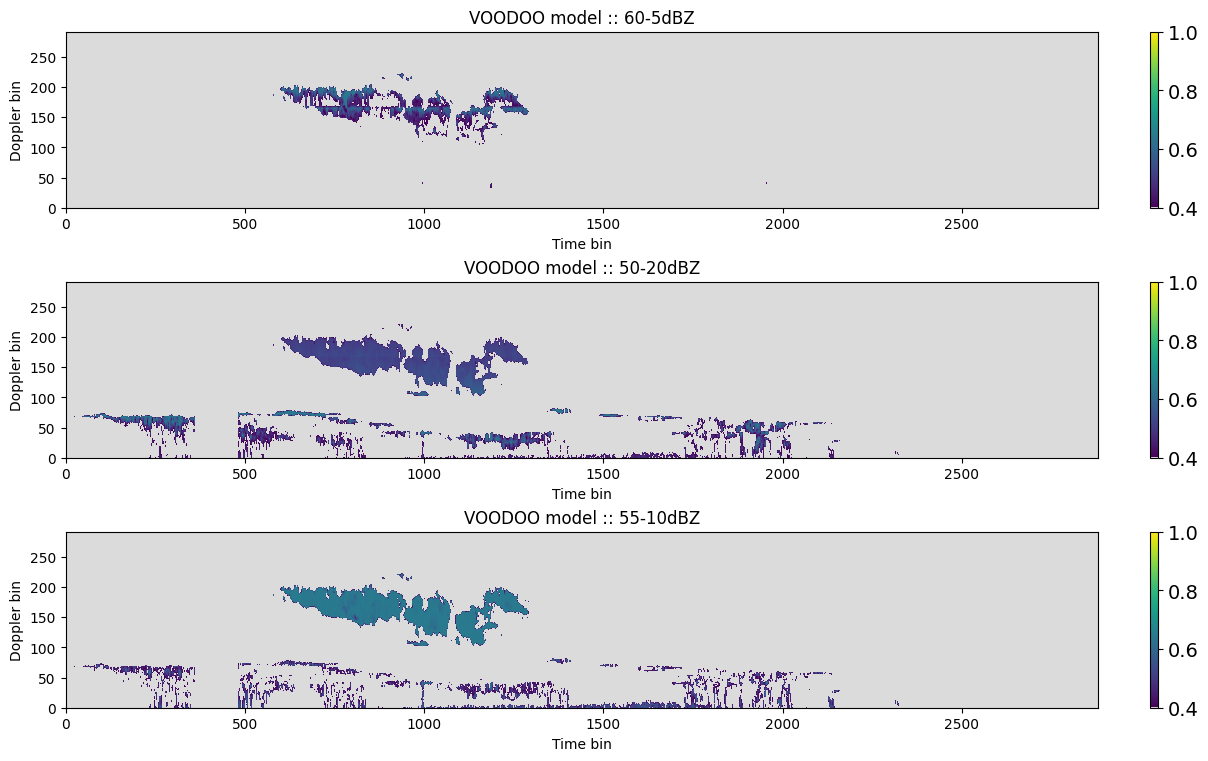

In [40]:
N_models = len(model_files)

fig, ax = plt.subplots(nrows=N_models, figsize=(12, N_models*2.5), constrained_layout=True)

for i in range(N_models):
    pmesh = ax[i].pcolormesh(model_output[i].T, cmap=get_voodoo_cmap(), vmin=0.4, vmax=1)
    cbar = fig.colorbar(pmesh, ax=ax[i])
    cbar.ax.tick_params(labelsize=14)
    ax[i].set_title(f'VOODOO model :: {model_files[i].split("--")[-1].split(".pt")[0]}')
    ax[i].set_xlabel('Time bin')
    ax[i].set_ylabel('Doppler bin')


# Plot the difference between the models


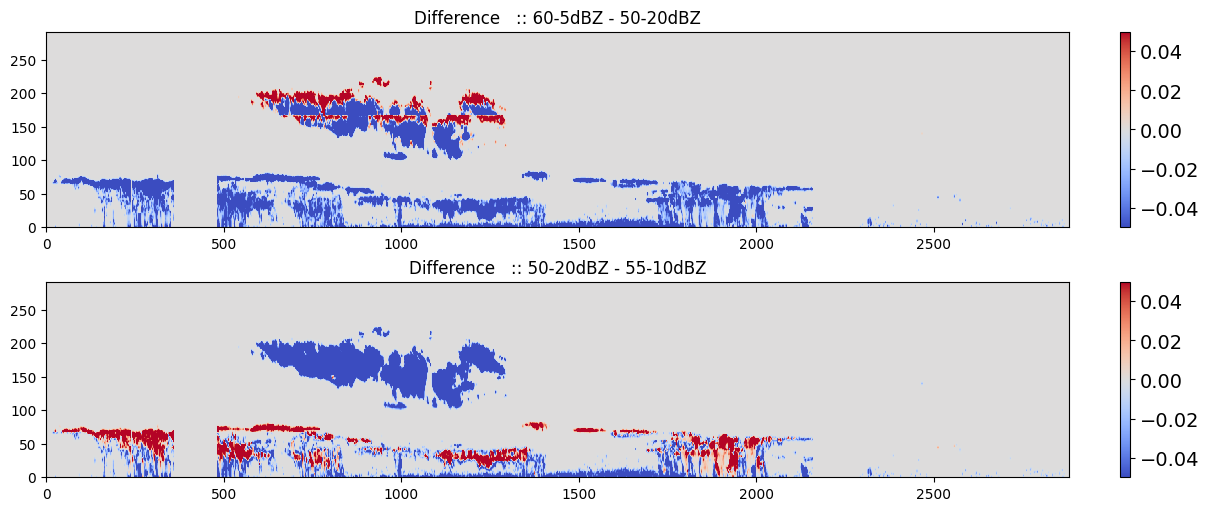

In [45]:
fig, ax = plt.subplots(nrows=N_models-1, figsize=(12, (N_models-1)*2.5), constrained_layout=True)

for i in range(N_models-1):
    m_diff = (model_output[i]-model_output[i+1]).T
    pmesh2 = ax[i].pcolormesh(m_diff, cmap='coolwarm', vmin=-0.05, vmax=0.05)
    cbar = fig.colorbar(pmesh2, ax=ax[i])
    cbar.ax.tick_params(labelsize=14)

    model_names = [txt.split('--')[-1].split('.pt')[0] for txt in model_files]
    ax[i].set_title(f'Difference   :: {model_names[i]} - {model_names[i+1]}')